# 딥러닝 final
## 201822037 통계학과 한민주

In [4]:
## import 
import torch
import matplotlib.pyplot as plt

# `1`. hi?hillo!! 

In [ ]:
txt = list('hi?hello!!')*100 
txt_x = txt[:-1]
txt_y = txt[1:]

In [ ]:
txt_x[:5], txt_y[:5]

(['h', 'i', '?', 'h', 'e'], ['i', '?', 'h', 'e', 'l'])

In [ ]:
## (1) ~ (6) 의 풀이에 공통적으로 필요한 과정
def f(txt,mapping):
    return [mapping[key] for key in txt] 

sig = torch.nn.Sigmoid()
soft = torch.nn.Softmax(dim=1)
tanh = torch.nn.Tanh()

mapping = {'!':0, '?':1,'h':2,'i':3,'e':4,'l':5,'o':6} 
x= torch.nn.functional.one_hot(torch.tensor(f(txt_x,mapping))).float().to("cuda:0")
y= torch.nn.functional.one_hot(torch.tensor(f(txt_y,mapping))).float().to("cuda:0")

## `(1)` `torch.nn.RNN()`을 이용하여 다음 문자를 예측하는 신경망을 설계하고 학습

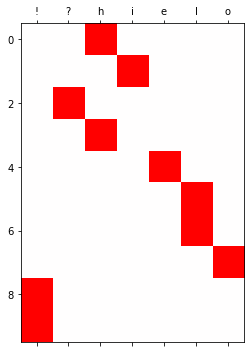

In [ ]:
torch.manual_seed(2)
# 문자 수 7 , 히든 노드 수 8
rnn = torch.nn.RNN(7,8).to("cuda:0") # 숙성
linr = torch.nn.Linear(8,7).to("cuda:0") # 조리
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters()) + list(linr.parameters()) , lr = 0.1)

# 학습
_water = torch.zeros(1,8).to("cuda:0") # 맹물
for epoc in range(500):
    hidden ,hT = rnn(x , _water)
    output = linr(hidden)
    loss = loss_fn(output , y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

# 예측 결과
yhat = soft(output)

# 시각화
plt.matshow(yhat.to("cpu").data[-10:], cmap = 'bwr' , vmin = -1 , vmax = 1)
plt.xticks(range(7),labels=['!','?','h','i','e','l','o']);

## `(2)` `torch.nn.RNNCell()`을 이용하여 다음 문자를 예측하는 신경망을 설계하고 학습하라.

In [ ]:
torch.manual_seed(2)
# 문자 수 7 , 히든 노드 수 8
rnncell = torch.nn.RNNCell(7,8).to("cuda:0") # 숙성
linr = torch.nn.Linear(8,7).to("cuda:0")  # 조리
loss_fn = torch.nn.CrossEntropyLoss()
optimizr =torch.optim.Adam(list(rnncell.parameters()) + list(linr.parameters()) , lr = 0.1)

# 학습
T = len(x)
for epoc in range(500):
  loss = 0
  ht = torch.zeros(1,8).to("cuda:0") # 맹물
  for t in range(T):
    xt , yt = x[[t]] , y[[t]]
    ht = rnncell(xt, ht)
    ot = linr(ht)
    loss = loss + loss_fn(ot , yt)

  loss.backward()
  optimizr.step()
  optimizr.zero_grad()

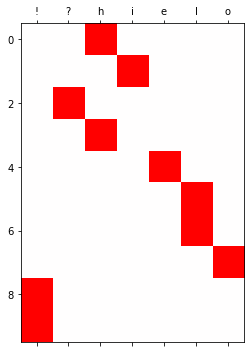

In [ ]:
## 시각화
hidden = torch.zeros(T,8).to("cuda:0")
# t=0
_water = torch.zeros(1,8).to("cuda:0")
hidden[[0]] = rnncell(x[[0]] , _water)
# t=1~T
for t in range(1,T):
  hidden[[t]] = rnncell(x[[t]] , hidden[[t-1]])

yhat = soft(linr(hidden))

plt.matshow(yhat.to("cpu").data[-10:], cmap = 'bwr' , vmin = -1 , vmax = 1)
plt.xticks(range(7),labels=['!','?','h','i','e','l','o']);

In [ ]:
hidden[-10:]

tensor([[-0.9679, -0.9950, -0.9289, -1.0000, -0.5564,  0.8603,  0.9990,  0.9944],
        [ 0.9903, -0.8151, -0.9909, -0.9904,  0.9272,  0.9998, -0.9996,  1.0000],
        [-0.9548,  0.9998, -0.9999,  0.9999,  0.9996,  0.9804, -0.9957,  0.8211],
        [-0.9466, -0.9930, -1.0000,  0.9991, -0.9786,  0.1578,  0.9726,  1.0000],
        [ 0.8594, -0.9947,  0.9350, -0.9999, -0.8948,  0.9994, -0.9888,  1.0000],
        [-0.9999,  0.9990, -0.1047,  0.9813,  0.9999, -0.9854,  0.8593,  0.9974],
        [ 0.8914, -0.3478,  0.9971,  0.9483,  0.7024, -0.9727,  0.8011,  0.9858],
        [-0.9803,  0.9817,  1.0000, -0.8223,  0.9799, -0.9995,  0.9829, -0.9970],
        [ 0.9987, -0.9898,  0.4381, -0.8355, -0.6550, -0.9926,  0.9995, -0.9512],
        [-0.9896, -0.9592,  0.9942, -1.0000, -0.9747,  0.5294,  0.9987, -0.9935]],
       device='cuda:0', grad_fn=<SliceBackward0>)

## `(3)` `torch.nn.Module`을 상속받은 클래스를 정의하고 (2)의 결과와 동일한 적합값이 나오는 신경망을 설계한 뒤 학습하라. (초기값을 적절하게 설정할 것)

In [ ]:
# 클래스 정의
class Myrnncell(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.i2h = torch.nn.Linear(7,8)
    self.h2h = torch.nn.Linear(8,8)
    self.tanh = torch.nn.Tanh()
  def forward(self, x , hidden):
    hidden = self.tanh(self.i2h(x) + self.h2h(hidden))
    return hidden

In [ ]:
myrnncell = Myrnncell().to("cuda:0") # 클래스로 만든 숙성 네트워크
torch.manual_seed(2)
rnncell = torch.nn.RNNCell(7,8).to("cuda:0") # (2)의 숙성 네트워크
linr =  torch.nn.Linear(8,7).to("cuda:0") # (2)의 조리 네트워크

In [ ]:
# 동일한 적합값이 나오도록 파라미터 초기화
myrnncell.i2h.weight.data = rnncell.weight_ih.data
myrnncell.h2h.weight.data = rnncell.weight_hh.data
myrnncell.i2h.bias.data = rnncell.bias_ih.data
myrnncell.h2h.bias.data = rnncell.bias_hh.data

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(myrnncell.parameters())+ list(linr.parameters()),lr = 0.1)

# 학습
T = len(x)
for epoc in range(500):
  loss = 0
  ht = torch.zeros(1,8).to("cuda:0") # 맹물
  for t in range(T):
    xt , yt = x[[t]] , y[[t]]
    ht = myrnncell(xt, ht)
    ot = linr(ht)
    loss = loss + loss_fn(ot , yt)

  loss.backward()
  optimizr.step()
  optimizr.zero_grad()

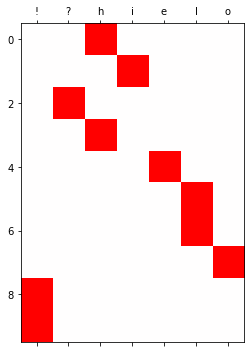

In [ ]:
## 시각화
hidden = torch.zeros(T,8).to("cuda:0")
# t=0
_water = torch.zeros(1,8).to("cuda:0")
hidden[[0]] = myrnncell(x[[0]] , _water)
# t=1~T
for t in range(1,T):
  hidden[[t]] = myrnncell(x[[t]] , hidden[[t-1]])

yhat = soft(linr(hidden))

plt.matshow(yhat.to("cpu").data[-10:], cmap = 'bwr' , vmin = -1 , vmax = 1)
plt.xticks(range(7),labels=['!','?','h','i','e','l','o']);

In [ ]:
hidden[-10:]

tensor([[-0.9679, -0.9950, -0.9289, -1.0000, -0.5564,  0.8603,  0.9990,  0.9944],
        [ 0.9903, -0.8151, -0.9909, -0.9904,  0.9272,  0.9998, -0.9996,  1.0000],
        [-0.9548,  0.9998, -0.9999,  0.9999,  0.9996,  0.9804, -0.9957,  0.8211],
        [-0.9466, -0.9930, -1.0000,  0.9991, -0.9786,  0.1578,  0.9726,  1.0000],
        [ 0.8594, -0.9947,  0.9350, -0.9999, -0.8948,  0.9994, -0.9888,  1.0000],
        [-0.9999,  0.9990, -0.1047,  0.9813,  0.9999, -0.9854,  0.8593,  0.9974],
        [ 0.8914, -0.3478,  0.9971,  0.9483,  0.7024, -0.9727,  0.8011,  0.9858],
        [-0.9803,  0.9817,  1.0000, -0.8223,  0.9799, -0.9995,  0.9829, -0.9970],
        [ 0.9987, -0.9898,  0.4381, -0.8355, -0.6550, -0.9926,  0.9995, -0.9512],
        [-0.9896, -0.9592,  0.9942, -1.0000, -0.9747,  0.5294,  0.9987, -0.9935]],
       device='cuda:0', grad_fn=<SliceBackward0>)

## `(4)` `torch.nn.LSTM()`을 이용하여 다음 문자를 예측하는 신경망을 설계하고 학습하라.

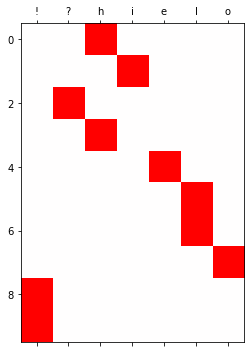

In [ ]:
torch.manual_seed(2)
## 글자 수 7 , 히든 노드 수 4
lstm = torch.nn.LSTM(7,4).to("cuda:0")
linr = torch.nn.Linear(4,7).to("cuda:0")

loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstm.parameters()) + list(linr.parameters()) , lr = 0.1)

## 학습
_water = torch.zeros(1,4).to("cuda:0")
for epoc in range(500):
  hidden , (hT , cT) = lstm(x , (_water , _water))
  output = linr(hidden)
  loss = loss_fn(output, y)
  loss.backward()
  optimizr.step()
  optimizr.zero_grad()

## 예측값
yhat = soft(output)

## 시각화
plt.matshow(yhat.to("cpu").data[-10:] , cmap = 'bwr' , vmin = -1 , vmax = 1)
plt.xticks(range(7),labels=['!','?','h','i','e','l','o']);

## `(5)` `torch.nn.LSTMCell()`을 이용하여 다음 문자를 예측하는 신경망을 설계하고 학습하라.

In [ ]:
torch.manual_seed(2)
lstm_cell = torch.nn.LSTMCell(7,4).to("cuda:0")
linr = torch.nn.Linear(4,7).to("cuda:0")

loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstm_cell.parameters()) + list(linr.parameters()) , lr = 0.1)

## 학습
T = len(x)
for epoc in range(500):
  ht = torch.zeros(1,4).to("cuda:0") # 맹물
  ct = torch.zeros(1,4).to("cuda:0") # 맹물
  loss = 0 
  for t in range(T):
    xt , yt = x[[t]] , y[[t]]
    ht ,ct = lstm_cell(xt , (ht , ct))
    ot = linr(ht)
    loss = loss + loss_fn(ot , yt)
  
  loss = loss/T
  loss.backward()
  optimizr.step()
  optimizr.zero_grad()

In [ ]:
ht , ct # (6)과 동일

(tensor([[-0.9872,  0.9561, -0.4765, -0.7996]], device='cuda:0',
        grad_fn=<ThnnFusedLstmCellBackward0>),
 tensor([[-2.5225,  1.9019, -0.5184, -1.1097]], device='cuda:0',
        grad_fn=<ThnnFusedLstmCellBackward0>))

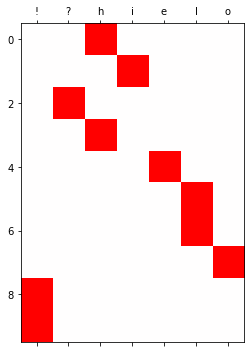

In [ ]:
## 시각화
hidden = torch.zeros(T,4).to("cuda:0")
cell = torch.zeros(T,4).to("cuda:0")
# t=0
_water = torch.zeros(1,4).to("cuda:0") # 맹물
hidden[[0]] , cell[[0]] = lstm_cell(x[[0]] , (_water , _water))
# t=1~T
for t in range(1,T):
  hidden[[t]] ,cell[[t]] = lstm_cell(x[[t]] , (hidden[[t-1]] , cell[[t-1]]))

yhat = soft(linr(hidden))

plt.matshow(yhat.to("cpu").data[-10:], cmap = 'bwr' , vmin = -1 , vmax = 1)
plt.xticks(range(7),labels=['!','?','h','i','e','l','o']);

In [ ]:
hidden[-10:]

tensor([[-0.9982,  0.9887,  0.6227,  0.3971],
        [-0.9694, -0.7590,  0.3315,  0.8687],
        [ 0.7001,  0.7592, -0.7579,  0.9706],
        [-0.6776,  0.9588,  0.7539,  0.9852],
        [ 0.6871, -0.7591,  0.6395,  0.9906],
        [ 0.8928, -0.9425,  0.0073, -0.7328],
        [ 0.4386, -0.9679,  0.1826, -0.9395],
        [-0.4807, -0.9821, -0.6621, -0.9802],
        [-0.9093,  0.7485, -0.9465, -0.9924],
        [-0.9872,  0.9561, -0.4765, -0.7996]], device='cuda:0',
       grad_fn=<SliceBackward0>)

## `(6)` (5)의 결과와 동일한 적합값을 출력하는 신경망을 직접 설계한 뒤 학습시켜라.

In [ ]:
torch.manual_seed(2)
lstm = torch.nn.LSTM(7,4).to("cuda:0") # (5)의 숙성 네트워크
linr = torch.nn.Linear(4,7).to("cuda:0") # (5)의 조리 네트워크

loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstm.parameters()) + list(linr.parameters()) , lr = 0.1)

In [ ]:
T = len(x)
for epoc in range(500):
  ht = torch.zeros(1,4).to("cuda:0") # 맹물
  ct = torch.zeros(1,4).to("cuda:0") # 맹물
  loss = 0

  hidden = torch.zeros(T,4).to("cuda:0")
  for t in range(T):
    xt , yt = x[[t]] , y[[t]]

    # step1: _ifgo
    _ifgo = xt @ lstm.weight_ih_l0.T + ht @ lstm.weight_hh_l0.T + lstm.bias_ih_l0 + lstm.bias_hh_l0
    # step2 : gate & gt
    input_gate = sig(_ifgo[: , 0:4])
    forget_gate = sig(_ifgo[: , 4:8])
    gt = tanh(_ifgo[:, 8:12])
    output_gate = sig(_ifgo[:,12:16])
    # step3 : ht , ct
    ct = forget_gate * ct + input_gate * gt
    ht = output_gate * tanh(ct)
    hidden[[t]] = ht ## 시각화용
    ot = linr(ht)
    loss = loss + loss_fn(ot , yt)
  
  loss = loss/T
  loss.backward()
  optimizr.step()
  optimizr.zero_grad()

In [ ]:
ht,ct  # (5)와 동일

(tensor([[-0.9872,  0.9561, -0.4765, -0.7996]], device='cuda:0',
        grad_fn=<MulBackward0>),
 tensor([[-2.5224,  1.9019, -0.5184, -1.1097]], device='cuda:0',
        grad_fn=<AddBackward0>))

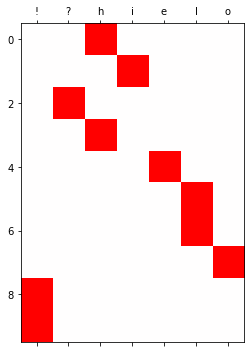

In [ ]:
## 시각화
yhat = soft(linr(hidden))

plt.matshow(yhat.to("cpu").data[-10:], cmap = 'bwr' , vmin = -1 , vmax = 1)
plt.xticks(range(7),labels=['!','?','h','i','e','l','o']);

In [ ]:
hidden[-10:] 

tensor([[-0.9982,  0.9887,  0.6227,  0.3971],
        [-0.9694, -0.7590,  0.3316,  0.8687],
        [ 0.7000,  0.7592, -0.7579,  0.9706],
        [-0.6775,  0.9587,  0.7539,  0.9852],
        [ 0.6871, -0.7591,  0.6394,  0.9905],
        [ 0.8928, -0.9425,  0.0073, -0.7328],
        [ 0.4385, -0.9679,  0.1825, -0.9395],
        [-0.4808, -0.9821, -0.6621, -0.9802],
        [-0.9093,  0.7485, -0.9465, -0.9924],
        [-0.9872,  0.9561, -0.4765, -0.7996]], device='cuda:0',
       grad_fn=<SliceBackward0>)

# `2` 다음을 읽고 참 거짓을 판단하여라.

In [2]:
## (1) LSTM은 RNN보다 장기기억에 유리하다.
# 참

In [ ]:
## (2)  torch.nn.Embedding(num_embeddings=2,embedding_dim=1)와 torch.nn.Linear(in_features=1,out_features=1)의 학습가능한 파라메터수는 같다.
# 참

In [ ]:
## (3) 차원이 (n,1) 인 임의의 텐서에 대하여 net(x)와 net.forword(x)의 출력결과는 같다.
# 참

In [ ]:
## (4) 아래와 같이 a,b,c,d 가 반복되는 문자열이 반복되는 자료에서 다음문자열을 맞추는 과업을 수행하기 위해서는 반드시 순환신경망의 형태로 설계해야만 한다.
# 거짓

In [ ]:
## (5) RNN 혹은 LSTM 으로 신경망을 설계할 시 손실함수는 항상 torch.nn.CrossEntropyLoss 를 사용해야 한다.
# 거짓